# Training the Model

This notebook builds a classification model to predict the outcome of football matches using engineered features from historical team performance data. The model is trained using CatBoost, a gradient boosting algorithm that handles missing values and categorical features natively. The goal is to classify match results as home win, away win, or draw based on team strength, form, and other match statistics.

### Imports

In [103]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint

match_data = pd.read_csv("../data/training_data.csv")

match_data=match_data.drop(columns=['DATE'],axis=1)

print(match_data.dtypes)
print(match_data.columns.tolist())
match_data.head()

HOME_TEAM                      object
HOME_STRENGTH                 float64
HOME_LEAGUE_STRENGTH          float64
HOME_GOALS_FOR_LAST3          float64
HOME_GOALS_AGAINST_LAST3      float64
HOME_STRENGTH_LAST3           float64
HOME_LEAGUE_STRENGTH_LAST3    float64
HOME_TARGET_LAST3             float64
HOME_FOULS_LAST3              float64
HOME_CORNERS_LAST3            float64
HOME_YELLOW_LAST3             float64
HOME_RED_LAST3                float64
HOME_FORM_LAST3               float64
AWAY_TEAM                      object
AWAY_STRENGTH                 float64
AWAY_LEAGUE_STRENGTH          float64
AWAY_GOALS_FOR_LAST3          float64
AWAY_GOALS_AGAINST_LAST3      float64
AWAY_STRENGTH_LAST3           float64
AWAY_LEAGUE_STRENGTH_LAST3    float64
AWAY_TARGET_LAST3             float64
AWAY_FOULS_LAST3              float64
AWAY_CORNERS_LAST3            float64
AWAY_YELLOW_LAST3             float64
AWAY_RED_LAST3                float64
AWAY_FORM_LAST3               float64
RESULT      

,HOME_TEAM,HOME_STRENGTH,HOME_LEAGUE_STRENGTH,HOME_GOALS_FOR_LAST3,HOME_GOALS_AGAINST_LAST3,HOME_STRENGTH_LAST3,HOME_LEAGUE_STRENGTH_LAST3,HOME_TARGET_LAST3,HOME_FOULS_LAST3,HOME_CORNERS_LAST3,...,AWAY_YELLOW_LAST3,AWAY_RED_LAST3,AWAY_FORM_LAST3,RESULT,STRENGTH_DIFF,LEAGUE_STRENGTH_DIFF,FORM_DIFF,HOME_GOAL_DIFF_LAST3,AWAY_GOAL_DIFF_LAST3,TOTAL_GOALS
0,AFC Ajax,84.3,76.2,3.000000,0.666667,84.3,76.2,NaN,NaN,NaN,...,NaN,NaN,3.0,H,-4.5,-2.4,0.0,2.333333,2.000000,6.0
1,AFC Ajax,84.3,76.2,2.666667,1.666667,84.3,76.2,NaN,NaN,NaN,...,2.000000,0.333333,3.0,A,-4.7,-2.4,0.0,1.000000,1.333333,1.0
2,AVS,75.7,78.6,1.333333,2.000000,75.7,78.6,3.000000,12.000000,2.666667,...,1.000000,0.333333,6.0,H,-2.6,0.0,0.0,-0.666667,0.000000,1.0
3,AVS,75.7,78.6,0.666667,1.666667,75.7,78.6,1.666667,11.333333,2.333333,...,2.333333,0.000000,7.0,D,-0.4,0.0,0.0,-1.000000,-1.333333,0.0
4,AVS,75.7,78.6,0.333333,2.000000,75.7,78.6,1.333333,11.333333,5.000000,...,1.666667,0.000000,7.0,A,-4.7,0.0,0.0,-1.666667,-1.000000,5.0


### Set Target and Categorical Features

In [104]:
# Define target and features
target_col = "RESULT"
categorical_cols = ["HOME_TEAM", "AWAY_TEAM"]

X = match_data.drop(columns=[target_col,"TOTAL_GOALS"])
y = match_data[target_col]

### Training Testing Split

In [105]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Create CatBoost Pool objects for better performance
train_pool = Pool(X_train, y_train, cat_features=categorical_cols)
test_pool = Pool(X_test, y_test, cat_features=categorical_cols)

### Train Model

In [106]:
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    verbose=100,
    random_seed=42
)

model.fit(train_pool, eval_set=test_pool)


0:	learn: 0.5030517	test: 0.5090455	best: 0.5090455 (0)	total: 45.8ms	remaining: 22.8s
100:	learn: 0.5232348	test: 0.5215221	best: 0.5221460 (81)	total: 5.8s	remaining: 22.9s
200:	learn: 0.5359273	test: 0.5258890	best: 0.5277604 (189)	total: 11.7s	remaining: 17.4s
300:	learn: 0.5505618	test: 0.5252651	best: 0.5277604 (189)	total: 17.8s	remaining: 11.8s
400:	learn: 0.5635317	test: 0.5233936	best: 0.5277604 (189)	total: 23.2s	remaining: 5.72s
499:	learn: 0.5764322	test: 0.5221460	best: 0.5277604 (189)	total: 28.3s	remaining: 0us

bestTest = 0.5277604492
bestIteration = 189

Shrink model to first 190 iterations.


### Feature Selection

As we can see, that the Accuracy is around 50% which is the same as random guess. So now we should try to possibly reduce the number of features that may be resulting in the model getting confused.

,Feature Id,Importances
0,STRENGTH_DIFF,24.833728
1,HOME_TEAM,15.151892
2,AWAY_TEAM,14.770099
3,AWAY_STRENGTH,2.942562
4,HOME_STRENGTH,2.723293
5,HOME_GOAL_DIFF_LAST3,2.704099
6,AWAY_GOALS_FOR_LAST3,2.702864
7,AWAY_STRENGTH_LAST3,2.591013
8,AWAY_GOAL_DIFF_LAST3,2.158713
9,HOME_LEAGUE_STRENGTH_LAST3,2.116878


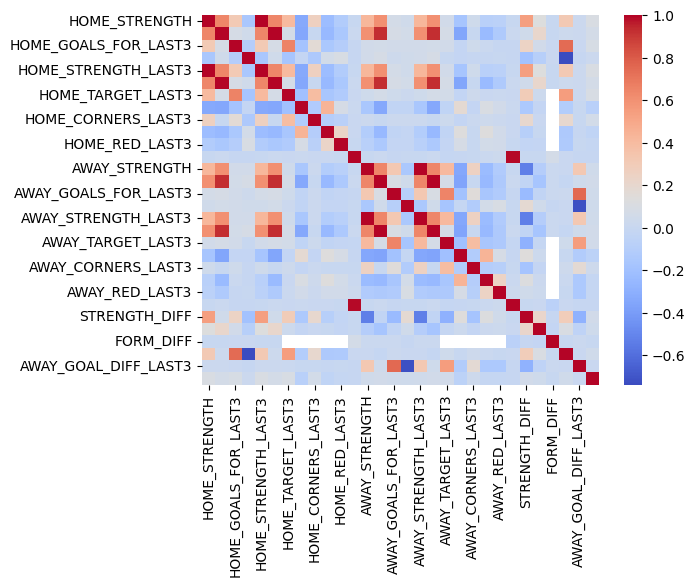

In [107]:
model.get_feature_importance(prettified=True)

numeric_data = match_data.select_dtypes(include=["number"])
sns.heatmap(numeric_data.corr(), annot=False, cmap='coolwarm')

model.get_feature_importance(prettified=True)

### Train a New Model, With Subset of Features

I am also going to change the target, as two-level classification is easier than three-level. So the outcomes will now be Home Win or No Home Win

In [108]:
drop_cols = [
    "HOME_YELLOW_LAST3",
    "HOME_CORNERS_LAST3",
    "AWAY_CORNERS_LAST3",
    "AWAY_YELLOW_LAST3",
    "HOME_FOULS_LAST3",
    "AWAY_FOULS_LAST3",
    "AWAY_RED_LAST3",
    "HOME_RED_LAST3",
    "FORM_DIFF",

]

# Create binary label: 1 if home team wins, 0 otherwise
match_data['HOME_WIN'] = match_data['RESULT'].apply(lambda x: 1 if x == 'H' else 0)

# Create a new dataframe without those columns + columns to exclude like teams, date, home win
X = match_data.drop(columns=drop_cols + ["HOME_TEAM", "AWAY_TEAM", "HOME_WIN","RESULT"])

# Target column
y = match_data["HOME_WIN"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# Initialize and train model
model = CatBoostClassifier(iterations=500, eval_metric='Accuracy', random_seed=42, verbose=100)
model.fit(train_pool, eval_set=test_pool, use_best_model=True)

# Evaluate
y_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Learning rate set to 0.082815
0:	learn: 0.6845610	test: 0.6893325	best: 0.6893325 (0)	total: 7.9ms	remaining: 3.94s
100:	learn: 0.7222222	test: 0.7099189	best: 0.7180287 (77)	total: 846ms	remaining: 3.34s
200:	learn: 0.7433070	test: 0.7105427	best: 0.7180287 (77)	total: 1.79s	remaining: 2.66s
300:	learn: 0.7626578	test: 0.7080474	best: 0.7180287 (77)	total: 2.73s	remaining: 1.8s
400:	learn: 0.7781939	test: 0.7005614	best: 0.7180287 (77)	total: 3.67s	remaining: 907ms
499:	learn: 0.7948398	test: 0.6980661	best: 0.7180287 (77)	total: 4.6s	remaining: 0us

bestTest = 0.7180286962
bestIteration = 77

Shrink model to first 78 iterations.
Test Accuracy: 0.718028696194635
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       885
           1       0.69      0.67      0.68       718

    accuracy                           0.72      1603
   macro avg       0.71      0.71      0.71      1603
weighted avg       0.72      0.72      0.72      1603



### Tune the Parameters of the Model

Now that we have achieved a higher accuracy by trying out different parameters to which achieves the highest accuracy

In [ ]:
param_dist = {
    'iterations': [300, 500, 700],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.5, 1],
    'random_strength': [1, 5, 10],
    'border_count': [32, 64, 128]
}

model = CatBoostClassifier(
    eval_metric='Accuracy',
    random_seed=42,
    verbose=0
)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter combinations to try
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:")
print(random_search.best_params_)

print("\nBest Cross-Validation Accuracy:")
print(random_search.best_score_)

# Use the best model to predict on test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters:
{'random_strength': 5, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 300, 'depth': 6, 'border_count': 128, 'bagging_temperature': 1}

Best Cross-Validation Accuracy:
0.7041892079345263

Test Accuracy: 0.7174048658764816
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       885
           1       0.68      0.69      0.69       718

    accuracy                           0.72      1603
   macro avg       0.71      0.71      0.71      1603
weighted avg       0.72      0.72      0.72      1603



## Number of Expected Goals Regressor

Since we already have a classifier to predict the outcome of each match, we can now make a different model to try and predict the number of expected goals for the upcoming matches. We will use the CatBoost Classifier again for this, the target for this model will be the `TOTAL_GOALS` column which we will convert into an `OVER_3_5` column. We will be predicting whether there will be over or under 3.5 goals in the match.

In [145]:
match_data['OVER_3_5'] = match_data['TOTAL_GOALS'].apply(lambda x: 1 if x > 3.5 else 0)

# Prepare data
drop_cols = [
    "RESULT", "HOME_TEAM", "AWAY_TEAM", "TOTAL_GOALS","FORM_DIFF","HOME_YELLOW_LAST3",
    "AWAY_YELLOW_LAST3","HOME_RED_LAST3","AWAY_RED_LAST3",
    "AWAY_FOULS_LAST3","HOME_FOULS_LAST3","OVER_2_5","OVER_3_5" # drop the regression target
]

X = match_data.drop(columns=drop_cols)
y = match_data["OVER_3_5"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    eval_metric='Accuracy',
    random_seed=42,
    verbose=100
)

clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(X.columns.tolist())

importances = clf.get_feature_importance()
feature_names = X.columns

# Combine into a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

0:	learn: 0.7145755	test: 0.7329173	best: 0.7329173 (0)	total: 9.96ms	remaining: 4.97s
100:	learn: 0.7202715	test: 0.7344774	best: 0.7344774 (97)	total: 662ms	remaining: 2.62s
200:	learn: 0.7315855	test: 0.7372855	best: 0.7372855 (198)	total: 1.3s	remaining: 1.93s
300:	learn: 0.7421973	test: 0.7347894	best: 0.7382215 (206)	total: 1.91s	remaining: 1.26s
400:	learn: 0.7535112	test: 0.7338534	best: 0.7382215 (206)	total: 2.52s	remaining: 623ms
499:	learn: 0.7615481	test: 0.7322933	best: 0.7382215 (206)	total: 3.14s	remaining: 0us

bestTest = 0.7382215289
bestIteration = 206

Shrink model to first 207 iterations.
Accuracy: 0.7382215288611544
              precision    recall  f1-score   support

           0       0.74      0.99      0.85      2349
           1       0.70      0.04      0.07       856

    accuracy                           0.74      3205
   macro avg       0.72      0.51      0.46      3205
weighted avg       0.73      0.74      0.64      3205

['HOME_STRENGTH', 'HOME_LEA